In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

In [2]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("0.05percent_2classes_processed.csv")
df8 = pd.read_csv("0.05percent_8classes_processed.csv")
df34 = pd.read_csv("0.05percent_34classes_processed.csv")

In [3]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

# Processing and Splitting our dataset Function
80% Train 20% Test

In [4]:
# First, modify your split function to return the scaler
def split(df_name):
    if df_name == "df2":
        label = "benign"
        df = df2.sample(n=400000, random_state=42)
    else:
        label = "label"
        if df_name == "df8": df = df8.sample(n=400000, random_state=42)
        else: df = df34.sample(n=400000, random_state=42)
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)  # Note: should use transform, not fit_transform here
    
    # encoding for XGBoost
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.transform(y_test)  # Should use transform instead of fit_transform
    
    return scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler

# Evaluation Functions

In [5]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    pred = model.predict(scaled_X_test)

    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    if model_name == "XGBoost":
        print(classification_report(y_test, pred, target_names = target_names, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);
    else:
        print(classification_report(y_test, pred, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);

In [6]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [7]:
# inspired from Zach
def get_weights(y_train):
    import math

    # Get counts in log10
    y_train_count = y_train.value_counts()
    y_log = y_train_count.apply(lambda x: math.log10(x))

    # Find the factor needed to bring minority classes to majority
    y_log_max = y_log.max()
    y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

    weight_dict = y_log.to_dict()

    return weight_dict

# Save models


In [8]:
import os
import pickle

def save_model(model, model_name, class_type):
    """
    Save a trained model to disk based on classification type
    """
    # Create directory structure if it doesn't exist
    base_dir = os.path.join("saved_models", f"class_{class_type}")
    os.makedirs(base_dir, exist_ok=True)

    # Create file name with no spaces
    file_name = model_name.replace(" ", "_").lower() + ".pkl"
    file_path = os.path.join(base_dir, file_name)

    # Save the model using pickle
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)

    print(f"Model '{model_name}' saved for {class_type}-class classification at: {file_path}")

def save_scaler(scaler, class_type):
    """
    Save the fitted StandardScaler object
    """
    base_dir = os.path.join("saved_models", f"class_{class_type}")
    os.makedirs(base_dir, exist_ok=True)

    file_path = os.path.join(base_dir, "standard_scaler.pkl")

    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"Scaler saved for {class_type}-class classification at: {file_path}")

def load_model(model_name, class_type):
    """
    Load a saved model from disk
    """
    file_name = model_name.replace(" ", "_").lower() + ".pkl"
    file_path = os.path.join("saved_models", f"class_{class_type}", file_name)

    with open(file_path, 'rb') as f:
        model = pickle.load(f)

    return model

def load_scaler(class_type):
    """
    Load a saved scaler from disk
    """
    file_path = os.path.join("saved_models", f"class_{class_type}", "standard_scaler.pkl")

    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)

    return scaler

# Example of how to save models after training
# For 2-class classification models
def save_models_for_class_2():
    # Save the scaler first
    # Make sure to get the scaler that was used to transform the training data
    save_scaler(scaler, 2)

    # Save all models
    save_model(logreg_model, "Logistic Regression", 2)
    save_model(clf, "Adaboost", 2)
    save_model(gbc, "Gradientboost", 2)
    save_model(knn, "KNN", 2)
    save_model(xgc, "XGBoost", 2)
    save_model(rfc, "Random Forest", 2)
    save_model(rfc, "Random Forest Bagging", 2)  # Make sure to rename variable

# Similar functions for 8-class and 34-class models
def save_models_for_class_8():
    save_scaler(scaler, 8)
    # Save all the 8-class models using the same pattern as above
    save_model(logreg_model, "Logistic Regression", 8)
    save_model(clf, "Adaboost", 8)
    save_model(gbc, "Gradientboost", 8)
    save_model(knn, "KNN", 8)
    save_model(xgc, "XGBoost", 8)
    save_model(rfc, "Random Forest", 8)
    save_model(rfcb, "Random Forest Bagging", 8)
    

def save_models_for_class_34():
    save_scaler(scaler, 34)
    # Save all the 34-class models using the same pattern as above
    save_model(logreg_model, "Logistic Regression", 34)
    save_model(clf, "Adaboost", 34)
    save_model(gbc, "Gradientboost", 34)
    save_model(knn, "KNN", 34)
    save_model(xgc, "XGBoost", 34)
    save_model(rfc, "Random Forest", 34)
    save_model(rfcb, "Random Forest Bagging", 34)

# Example of how to load and use a saved model for prediction
def load_and_predict(model_name, class_type, X_new):
    """
    Load a model and scaler, and make predictions on new data

    Parameters:
    -----------
    model_name : str
        Name of the model to load
    class_type : int
        Classification type (2, 8, or 34)
    X_new : array-like
        New data to predict on

    Returns:
    --------
    predictions : array
        Predicted classes
    """
    # Load model and scaler
    model = load_model(model_name, class_type)
    scaler = load_scaler(class_type)

    # Scale the new data
    X_new_scaled = scaler.transform(X_new)

    # Make predictions
    predictions = model.predict(X_new_scaled)

    return predictions

# **1-Supervised learning**

## 2 Classes

In [9]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler = split("df2")

In [10]:
weight_dict = get_weights(y_train)
weight_dict

{False: 1.0, True: 41.6552919221541}

In [11]:
# essential for XGBoost
target_names = ["Attack", "Benign"]

### Logistic Regression

              precision    recall  f1-score   support

       False      0.993     0.994     0.994     78124
        True      0.747     0.695     0.720      1876

    accuracy                          0.987     80000
   macro avg      0.870     0.844     0.857     80000
weighted avg      0.987     0.987     0.987     80000



<Figure size 1200x600 with 0 Axes>

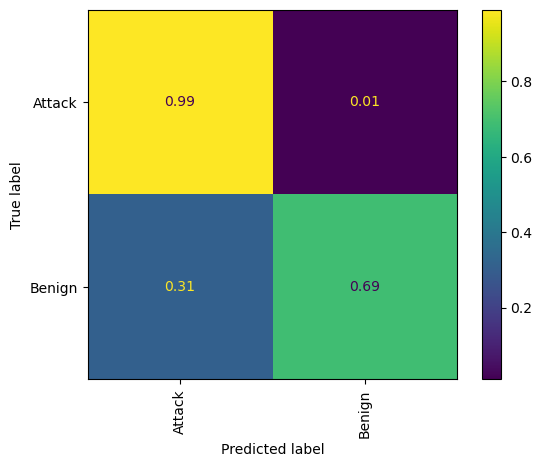

In [12]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")



### Adaboost

              precision    recall  f1-score   support

       False      0.998     0.997     0.997     78124
        True      0.877     0.921     0.898      1876

    accuracy                          0.995     80000
   macro avg      0.937     0.959     0.948     80000
weighted avg      0.995     0.995     0.995     80000



<Figure size 1200x600 with 0 Axes>

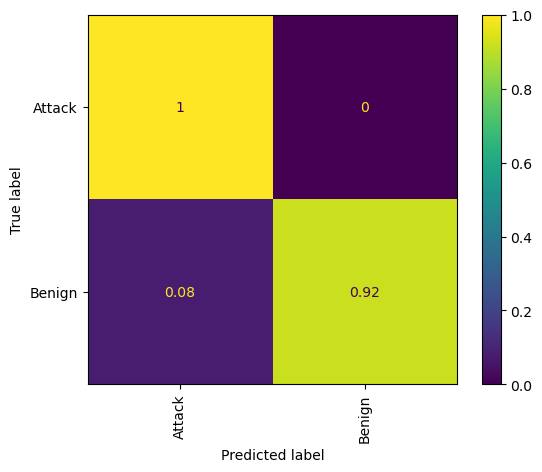

In [13]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 2, "Adaboost")


### Gradientboost

              precision    recall  f1-score   support

       False      0.998     0.998     0.998     78124
        True      0.907     0.912     0.910      1876

    accuracy                          0.996     80000
   macro avg      0.953     0.955     0.954     80000
weighted avg      0.996     0.996     0.996     80000



<Figure size 1200x600 with 0 Axes>

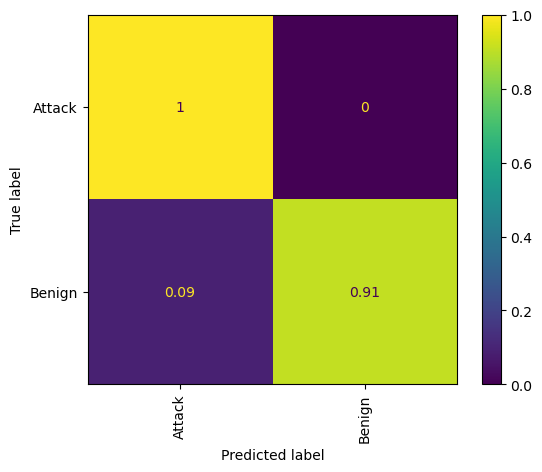

In [14]:
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 2, "Gradientboost")


### KNN

              precision    recall  f1-score   support

       False      0.996     0.994     0.995     78124
        True      0.783     0.840     0.810      1876

    accuracy                          0.991     80000
   macro avg      0.890     0.917     0.903     80000
weighted avg      0.991     0.991     0.991     80000



<Figure size 1200x600 with 0 Axes>

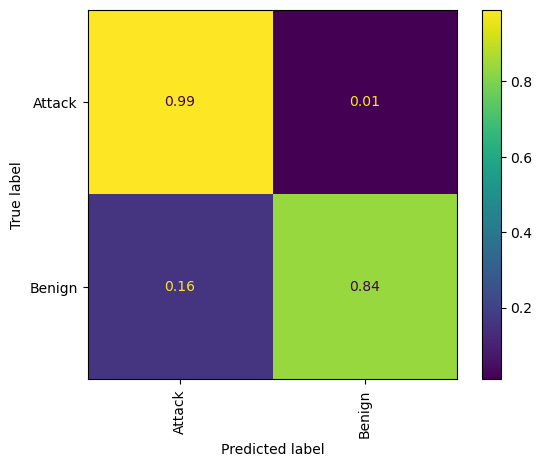

In [15]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 2, "KNN")



### XGBoost

              precision    recall  f1-score   support

      Attack      0.996     0.996     0.996     78124
      Benign      0.839     0.836     0.837      1876

    accuracy                          0.992     80000
   macro avg      0.917     0.916     0.917     80000
weighted avg      0.992     0.992     0.992     80000



<Figure size 1200x600 with 0 Axes>

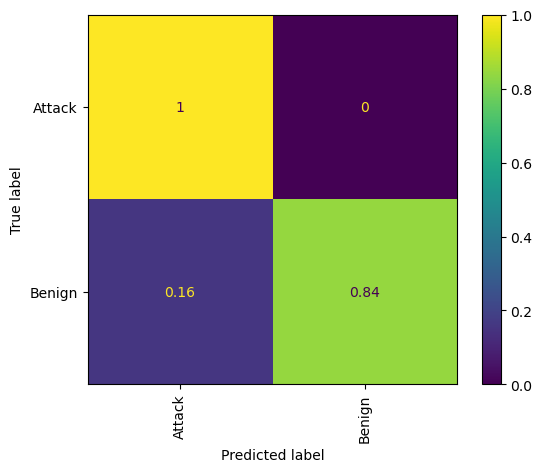

In [16]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 2, "XGBoost")



### Random Forest

              precision    recall  f1-score   support

       False      0.999     0.998     0.998     78124
        True      0.925     0.949     0.937      1876

    accuracy                          0.997     80000
   macro avg      0.962     0.973     0.968     80000
weighted avg      0.997     0.997     0.997     80000



<Figure size 1200x600 with 0 Axes>

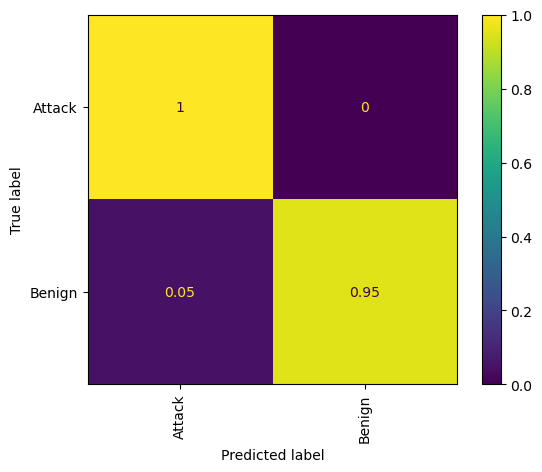

In [17]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest")


/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

       False      1.000     0.989     0.995     78124
        True      0.688     0.999     0.815      1876

    accuracy                          0.989     80000
   macro avg      0.844     0.994     0.905     80000
weighted avg      0.993     0.989     0.990     80000



<Figure size 1200x600 with 0 Axes>

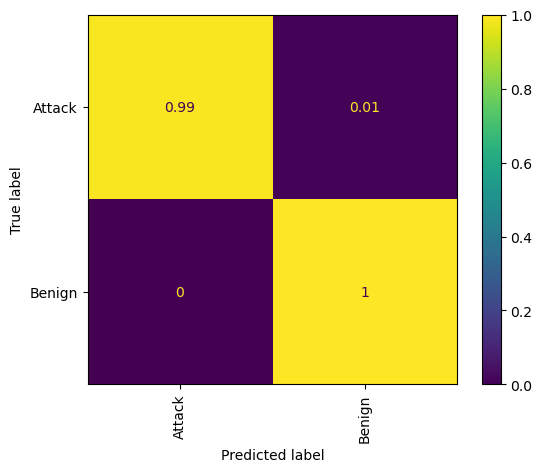

In [18]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Bagging")


In [19]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2
# Add:

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.987325,0.9951,0.99575,0.990788,0.992387,0.996988,0.98935
Recall,0.844459,0.958733,0.954903,0.916986,0.916244,0.973486,0.994027
Precision,0.869905,0.93737,0.952549,0.889666,0.91733,0.961723,0.843967
F1-Score,0.856703,0.947783,0.953723,0.902836,0.916786,0.967526,0.90465


In [20]:
save_models_for_class_2() 

Scaler saved for 2-class classification at: saved_models/class_2/standard_scaler.pkl
Model 'Logistic Regression' saved for 2-class classification at: saved_models/class_2/logistic_regression.pkl
Model 'Adaboost' saved for 2-class classification at: saved_models/class_2/adaboost.pkl
Model 'Gradientboost' saved for 2-class classification at: saved_models/class_2/gradientboost.pkl
Model 'KNN' saved for 2-class classification at: saved_models/class_2/knn.pkl
Model 'XGBoost' saved for 2-class classification at: saved_models/class_2/xgboost.pkl
Model 'Random Forest' saved for 2-class classification at: saved_models/class_2/random_forest.pkl
Model 'Random Forest Bagging' saved for 2-class classification at: saved_models/class_2/random_forest_bagging.pkl


## 8 Classes

In [21]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler  = split("df8")

In [22]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS': 1.0,
 'DoS': 4.217345664488805,
 'Mirai': 12.836500853853368,
 'Benign': 31.061183684350862,
 'Spoofing': 68.8392909896603,
 'Recon': 95.61797291752158,
 'Web': 1429.5766871165652,
 'BruteForce': 2709.5465116279092}

In [23]:
y_test.value_counts()

label
DDoS          58255
DoS           13813
Mirai          4538
Benign         1876
Spoofing        846
Recon           609
Web              41
BruteForce       22
Name: count, dtype: int64

In [24]:
# essential for XGBoost
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

### Logistic Regression

              precision    recall  f1-score   support

      Benign      0.695     0.888     0.780      1876
  BruteForce      1.000     0.091     0.167        22
        DDoS      0.824     0.991     0.900     58255
         DoS      0.700     0.111     0.192     13813
       Mirai      0.991     0.987     0.989      4538
       Recon      0.573     0.340     0.427       609
    Spoofing      0.767     0.404     0.529       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.825     80000
   macro avg      0.694     0.476     0.498     80000
weighted avg      0.806     0.825     0.772     80000



<Figure size 1200x600 with 0 Axes>

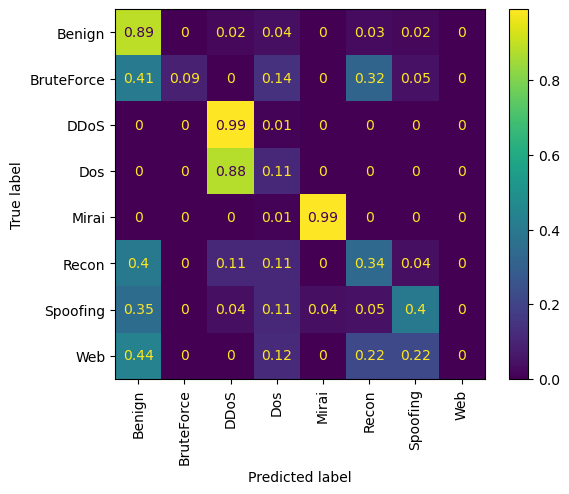

In [25]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42,n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 8, "Logistic Regression")


### Adaboost

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign      0.767     0.916     0.835      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.998     0.997     0.998     58255
         DoS      0.995     0.991     0.993     13813
       Mirai      0.993     0.981     0.987      4538
       Recon      0.521     0.558     0.539       609
    Spoofing      0.754     0.597     0.666       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.985     80000
   macro avg      0.629     0.630     0.627     80000
weighted avg      0.985     0.985     0.985     80000



/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x600 with 0 Axes>

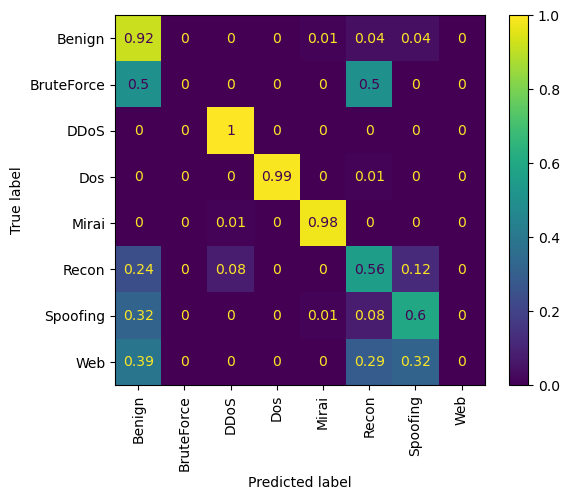

In [26]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 8, "Adaboost")


### Gradientboost

              precision    recall  f1-score   support

      Benign      0.936     0.832     0.881      1876
  BruteForce      0.778     0.636     0.700        22
        DDoS      0.996     1.000     0.998     58255
         DoS      0.999     0.999     0.999     13813
       Mirai      0.996     0.999     0.998      4538
       Recon      0.785     0.772     0.778       609
    Spoofing      0.824     0.823     0.823       846
         Web      0.405     0.366     0.385        41

    accuracy                          0.992     80000
   macro avg      0.840     0.803     0.820     80000
weighted avg      0.991     0.992     0.992     80000



<Figure size 1200x600 with 0 Axes>

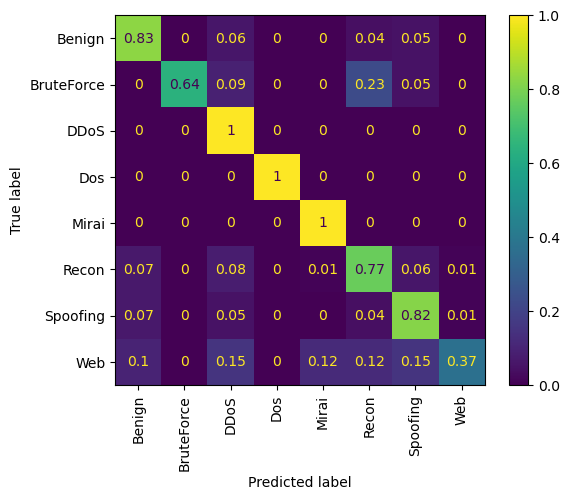

In [27]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)


evaluate(gbc, y_test, target_names, 8, "Gradientboost")



# KNN

              precision    recall  f1-score   support

      Benign      0.736     0.927     0.820      1876
  BruteForce      1.000     0.091     0.167        22
        DDoS      0.958     0.985     0.971     58255
         DoS      0.928     0.822     0.872     13813
       Mirai      0.998     0.990     0.994      4538
       Recon      0.692     0.524     0.596       609
    Spoofing      0.744     0.491     0.591       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.946     80000
   macro avg      0.757     0.604     0.626     80000
weighted avg      0.945     0.946     0.944     80000



<Figure size 1200x600 with 0 Axes>

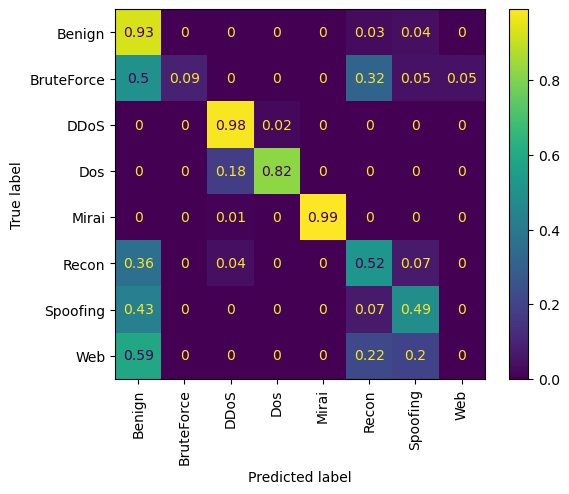

In [28]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 8, "KNN")



## XGBoost

/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

      Benign      0.896     0.933     0.914      1876
  BruteForce      1.000     0.136     0.240        22
        DDoS      1.000     1.000     1.000     58255
         Dos      0.999     0.999     0.999     13813
       Mirai      1.000     0.999     0.999      4538
       Recon      0.796     0.788     0.792       609
    Spoofing      0.822     0.798     0.810       846
         Web      0.357     0.122     0.182        41

    accuracy                          0.994     80000
   macro avg      0.859     0.722     0.742     80000
weighted avg      0.993     0.994     0.993     80000



<Figure size 1200x600 with 0 Axes>

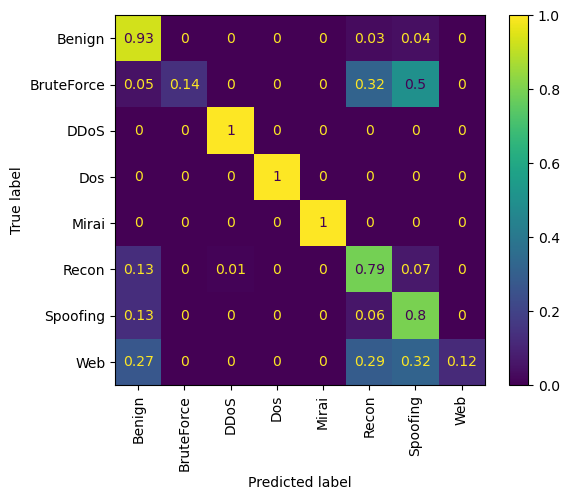

In [29]:
# Required to be trained on scaled_X_train, encoded_y_train
# evaluate parameter for y_test to be encoded y_test
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 ,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 8, "XGBoost")


## Random Forest

              precision    recall  f1-score   support

      Benign      0.895     0.962     0.927      1876
  BruteForce      1.000     0.045     0.087        22
        DDoS      1.000     1.000     1.000     58255
         DoS      1.000     0.999     0.999     13813
       Mirai      1.000     1.000     1.000      4538
       Recon      0.827     0.801     0.814       609
    Spoofing      0.894     0.820     0.856       846
         Web      1.000     0.098     0.178        41

    accuracy                          0.995     80000
   macro avg      0.952     0.716     0.733     80000
weighted avg      0.995     0.995     0.994     80000



<Figure size 1200x600 with 0 Axes>

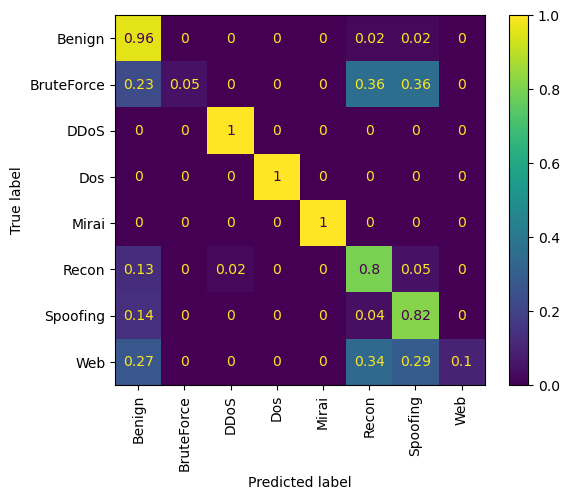

In [30]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 ,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest")


/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

      Benign      0.896     0.792     0.841      1876
  BruteForce      0.039     0.727     0.074        22
        DDoS      1.000     0.976     0.987     58255
         DoS      0.954     0.980     0.967     13813
       Mirai      0.997     0.985     0.991      4538
       Recon      0.395     0.639     0.488       609
    Spoofing      0.509     0.661     0.575       846
         Web      0.067     0.561     0.120        41

    accuracy                          0.966     80000
   macro avg      0.607     0.790     0.630     80000
weighted avg      0.979     0.966     0.972     80000



<Figure size 1200x600 with 0 Axes>

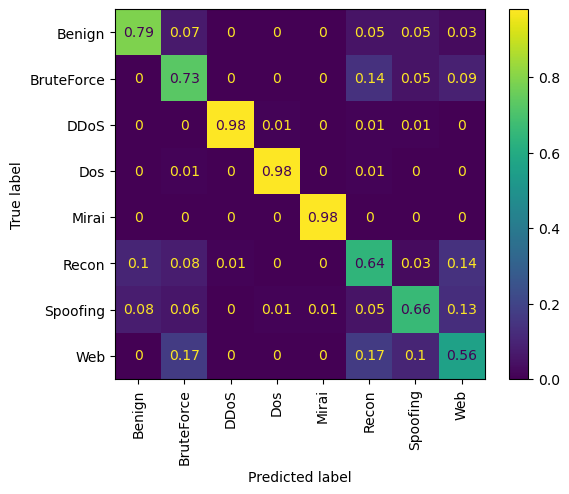

In [31]:
# Bagging-balanced
rfcb = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True ,n_jobs=-1)
rfcb.fit(scaled_X_train, y_train)

evaluate(rfcb, y_test, target_names, 8, "Random Forest - Bagging")


In [32]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.82475,0.985012,0.9917,0.946163,0.9936,0.9947,0.966337
Recall,0.476462,0.629999,0.80335,0.603714,0.721853,0.71562,0.789926
Precision,0.693832,0.628506,0.839952,0.756951,0.858733,0.951963,0.607234
F1-Score,0.497933,0.627205,0.820249,0.626488,0.741981,0.732571,0.630485


In [33]:
save_models_for_class_8()

Scaler saved for 8-class classification at: saved_models/class_8/standard_scaler.pkl
Model 'Logistic Regression' saved for 8-class classification at: saved_models/class_8/logistic_regression.pkl
Model 'Adaboost' saved for 8-class classification at: saved_models/class_8/adaboost.pkl
Model 'Gradientboost' saved for 8-class classification at: saved_models/class_8/gradientboost.pkl
Model 'KNN' saved for 8-class classification at: saved_models/class_8/knn.pkl
Model 'XGBoost' saved for 8-class classification at: saved_models/class_8/xgboost.pkl
Model 'Random Forest' saved for 8-class classification at: saved_models/class_8/random_forest.pkl
Model 'Random Forest Bagging' saved for 8-class classification at: saved_models/class_8/random_forest_bagging.pkl


# 34 Classes

In [34]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler  = split("df34")

In [35]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS-ICMP_Flood': 1.0,
 'DDoS-UDP_Flood': 1.3327485222273208,
 'DDoS-TCP_Flood': 1.6057560975609746,
 'DDoS-PSHACK_Flood': 1.7570010319182976,
 'DDoS-SYN_Flood': 1.7736628470850218,
 'DDoS-RSTFINFlood': 1.7863680764082344,
 'DDoS-SynonymousIP_Flood': 1.9886825889081294,
 'DoS-UDP_Flood': 2.1790379523389207,
 'DoS-TCP_Flood': 2.6990816661200356,
 'DoS-SYN_Flood': 3.578302775563443,
 'BenignTraffic': 6.580967612954817,
 'Mirai-greeth_flood': 7.218859649122804,
 'Mirai-udpplain': 7.982056256062071,
 'Mirai-greip_flood': 9.630778232884722,
 'DDoS-ICMP_Fragmentation': 15.928064516129023,
 'MITM-ArpSpoofing': 23.291037735849052,
 'DDoS-UDP_Fragmentation': 24.299704724409448,
 'DDoS-ACK_Fragmentation': 25.452061855670088,
 'DNS_Spoofing': 39.03320158102764,
 'Recon-HostDiscovery': 52.58466453674118,
 'Recon-OSScan': 73.04289940828397,
 'Recon-PortScan': 87.85943060498215,
 'DoS-HTTP_Flood': 98.95190380761521,
 'VulnerabilityScan': 201.5387755102039,
 'DDoS-HTTP_Flood': 259.87894736842094,
 

In [36]:
y_test.value_counts()

label
DDoS-ICMP_Flood            12344
DDoS-UDP_Flood              9262
DDoS-TCP_Flood              7687
DDoS-PSHACK_Flood           7026
DDoS-SYN_Flood              6960
DDoS-RSTFINFlood            6910
DDoS-SynonymousIP_Flood     6207
DoS-UDP_Flood               5665
DoS-TCP_Flood               4574
DoS-SYN_Flood               3450
BenignTraffic               1875
Mirai-greeth_flood          1710
Mirai-udpplain              1546
Mirai-greip_flood           1282
DDoS-ICMP_Fragmentation      775
MITM-ArpSpoofing             530
DDoS-UDP_Fragmentation       508
DDoS-ACK_Fragmentation       485
DNS_Spoofing                 316
Recon-HostDiscovery          235
Recon-OSScan                 169
Recon-PortScan               140
DoS-HTTP_Flood               125
VulnerabilityScan             61
DDoS-HTTP_Flood               48
DDoS-SlowLoris                43
DictionaryBruteForce          22
BrowserHijacking              11
SqlInjection                  10
CommandInjection               9
XSS 

In [37]:
# essential for XGBoost
target_names = list(y_test.unique())

## Logistic Regression

In [38]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42, n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 34, "Logistic Regression")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.674     0.927     0.781      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.884     0.157     0.266       485
        DDoS-HTTP_Flood      0.327     0.375     0.350        48
        DDoS-ICMP_Flood      0.972     0.996     0.984     12344
DDoS-ICMP_Fragmentation      0.612     0.981     0.754       775
      DDoS-PSHACK_Flood      0.999     0.983     0.991      7026
       DDoS-RSTFINFlood      0.999     0.999     0.999      6910
         DDoS-SYN_Flood      0.650     0.967     0.777      6960
         DDoS-SlowLoris      0.222     0.093     0.131        43
DDoS-SynonymousIP_Flood      0.748     0.683     0.714      6207
         DDoS-TCP_Flood      0.620     0.945     0.748      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Adaboost

In [39]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42 )
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 34, "Adaboost")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.546     0.946     0.693      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.857     0.918     0.886       485
        DDoS-HTTP_Flood      0.000     0.000     0.000        48
        DDoS-ICMP_Flood      1.000     0.996     0.998     12344
DDoS-ICMP_Fragmentation      0.976     0.839     0.902       775
      DDoS-PSHACK_Flood      1.000     0.980     0.990      7026
       DDoS-RSTFINFlood      0.996     0.998     0.997      6910
         DDoS-SYN_Flood      0.663     0.957     0.783      6960
         DDoS-SlowLoris      0.000     0.000     0.000        43
DDoS-SynonymousIP_Flood      0.553     0.026     0.050      6207
         DDoS-TCP_Flood      0.405     0.967     0.570      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gradientboost

In [40]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 34, "Gradientboost")


                         precision    recall  f1-score   support

       Backdoor_Malware      0.667     0.500     0.571         4
          BenignTraffic      0.941     0.862     0.900      1875
       BrowserHijacking      0.389     0.636     0.483        11
       CommandInjection      0.500     0.444     0.471         9
 DDoS-ACK_Fragmentation      0.996     0.990     0.993       485
        DDoS-HTTP_Flood      0.935     0.896     0.915        48
        DDoS-ICMP_Flood      0.998     1.000     0.999     12344
DDoS-ICMP_Fragmentation      0.997     0.991     0.994       775
      DDoS-PSHACK_Flood      0.998     1.000     0.999      7026
       DDoS-RSTFINFlood      1.000     1.000     1.000      6910
         DDoS-SYN_Flood      0.999     1.000     0.999      6960
         DDoS-SlowLoris      1.000     0.953     0.976        43
DDoS-SynonymousIP_Flood      1.000     1.000     1.000      6207
         DDoS-TCP_Flood      0.992     1.000     0.996      7687
         DDoS-UDP_Flood 

## KNN

In [41]:
knn = KNeighborsClassifier(n_neighbors = 8, n_jobs=-1)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 34, "KNN")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.714     0.958     0.818      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.690     0.625     0.656       485
        DDoS-HTTP_Flood      0.542     0.667     0.598        48
        DDoS-ICMP_Flood      0.988     0.993     0.991     12344
DDoS-ICMP_Fragmentation      0.723     0.836     0.776       775
      DDoS-PSHACK_Flood      0.999     0.996     0.998      7026
       DDoS-RSTFINFlood      0.999     0.999     0.999      6910
         DDoS-SYN_Flood      0.901     0.964     0.931      6960
         DDoS-SlowLoris      0.686     0.558     0.615        43
DDoS-SynonymousIP_Flood      0.957     0.944     0.951      6207
         DDoS-TCP_Flood      0.930     0.970     0.950      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost

In [42]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 , n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 34, "XGBoost")


/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                         precision    recall  f1-score   support

          BenignTraffic      0.000     0.000     0.000         4
         DDoS-UDP_Flood      0.602     0.418     0.494      1875
          DoS-UDP_Flood      0.000     0.000     0.000        11
      DDoS-PSHACK_Flood      0.000     0.000     0.000         9
         DDoS-SYN_Flood      0.000     0.000     0.000       485
DDoS-SynonymousIP_Flood      0.000     0.000     0.000        48
         Recon-PortScan      0.961     0.510     0.666     12344
        DDoS-ICMP_Flood      0.667     0.005     0.010       775
         DDoS-TCP_Flood      0.931     0.849     0.888      7026
       DDoS-RSTFINFlood      0.000     0.000     0.000      6910
           DNS_Spoofing      0.122     0.217     0.156      6960
      Mirai-greip_flood      0.000     0.000     0.000        43
DDoS-ICMP_Fragmentation      0.000     0.000     0.000      6207
          DoS-SYN_Flood      0.139     0.876     0.241      7687
          DoS-TCP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

## Random Forest

In [43]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 , n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest")



/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.858     0.989     0.919      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.996     0.986     0.991       485
        DDoS-HTTP_Flood      1.000     0.958     0.979        48
        DDoS-ICMP_Flood      1.000     1.000     1.000     12344
DDoS-ICMP_Fragmentation      0.995     0.994     0.994       775
      DDoS-PSHACK_Flood      1.000     0.999     1.000      7026
       DDoS-RSTFINFlood      1.000     1.000     1.000      6910
         DDoS-SYN_Flood      0.999     0.999     0.999      6960
         DDoS-SlowLoris      0.741     0.930     0.825        43
DDoS-SynonymousIP_Flood      1.000     1.000     1.000      6207
         DDoS-TCP_Flood      1.000     0.999     1.000      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Bagging-balanced
rfcb = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfcb.fit(scaled_X_train, y_train)
evaluate(rfcb, y_test, target_names, 34, "Random Forest - Bagging")

/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

                         precision    recall  f1-score   support

       Backdoor_Malware      0.025     0.750     0.049         4
          BenignTraffic      0.847     0.309     0.453      1875
       BrowserHijacking      0.012     0.273     0.023        11
       CommandInjection      0.045     0.444     0.082         9
 DDoS-ACK_Fragmentation      0.807     0.930     0.864       485
        DDoS-HTTP_Flood      0.221     0.708     0.337        48
        DDoS-ICMP_Flood      0.974     0.993     0.984     12344
DDoS-ICMP_Fragmentation      0.997     0.899     0.946       775
      DDoS-PSHACK_Flood      0.992     0.996     0.994      7026
       DDoS-RSTFINFlood      0.999     0.998     0.998      6910
         DDoS-SYN_Flood      0.953     0.949     0.951      6960
         DDoS-SlowLoris      0.247     0.558     0.343        43
DDoS-SynonymousIP_Flood      0.975     0.948     0.961      6207
         DDoS-TCP_Flood      0.985     0.985     0.985      7687
         DDoS-UDP_Flood 

In [45]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.783575,0.723513,0.99035,0.932013,0.270375,0.99285,0.906525
Recall,0.416319,0.348667,0.815507,0.580547,0.08718,0.71123,0.648675
Precision,0.501909,0.385901,0.828673,0.625427,0.113056,0.754803,0.553339
F1-Score,0.409058,0.323045,0.817736,0.589563,0.075797,0.719293,0.530971


In [46]:
save_models_for_class_34()

Scaler saved for 34-class classification at: saved_models/class_34/standard_scaler.pkl
Model 'Logistic Regression' saved for 34-class classification at: saved_models/class_34/logistic_regression.pkl
Model 'Adaboost' saved for 34-class classification at: saved_models/class_34/adaboost.pkl
Model 'Gradientboost' saved for 34-class classification at: saved_models/class_34/gradientboost.pkl
Model 'KNN' saved for 34-class classification at: saved_models/class_34/knn.pkl
Model 'XGBoost' saved for 34-class classification at: saved_models/class_34/xgboost.pkl
Model 'Random Forest' saved for 34-class classification at: saved_models/class_34/random_forest.pkl
Model 'Random Forest Bagging' saved for 34-class classification at: saved_models/class_34/random_forest_bagging.pkl


# Metric Plot

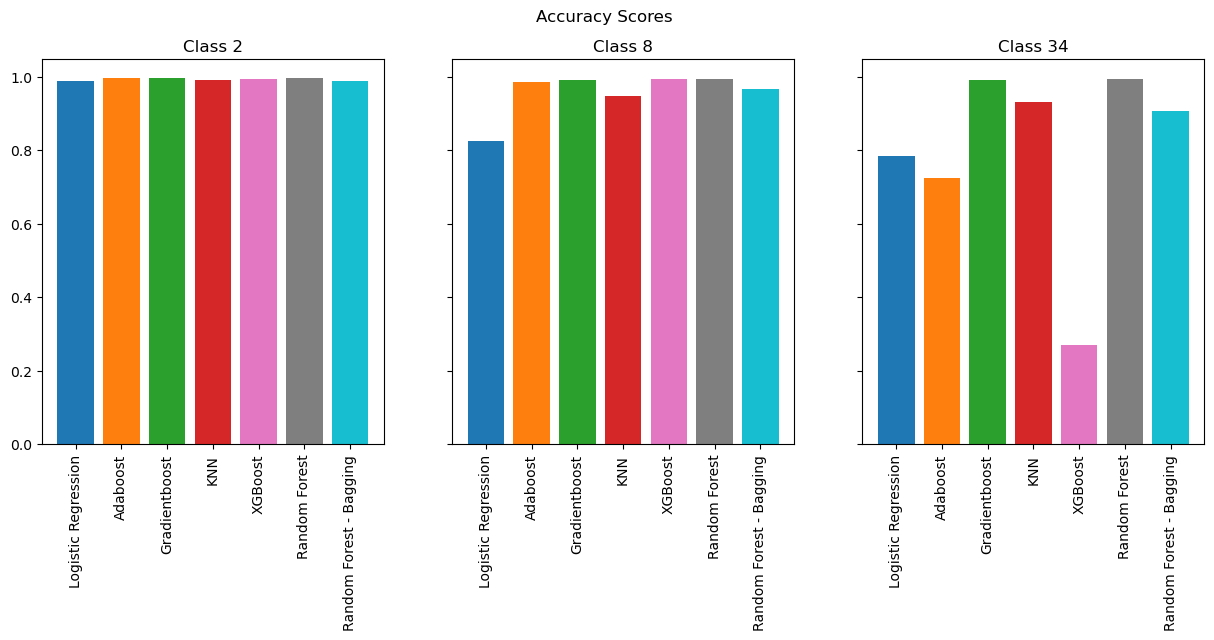

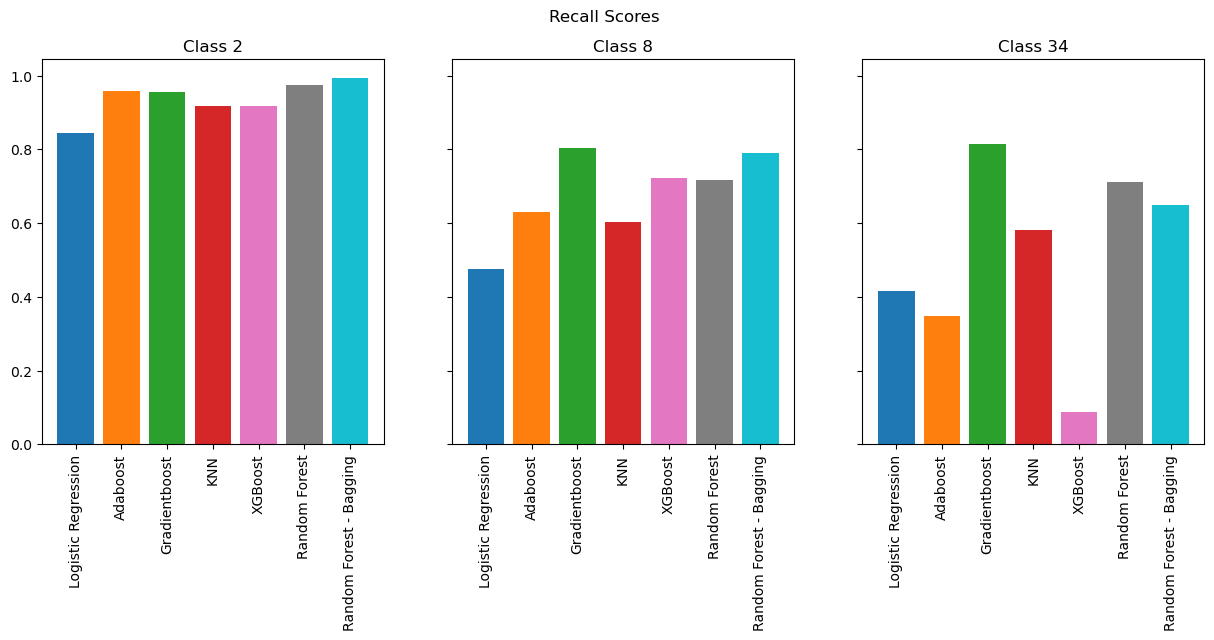

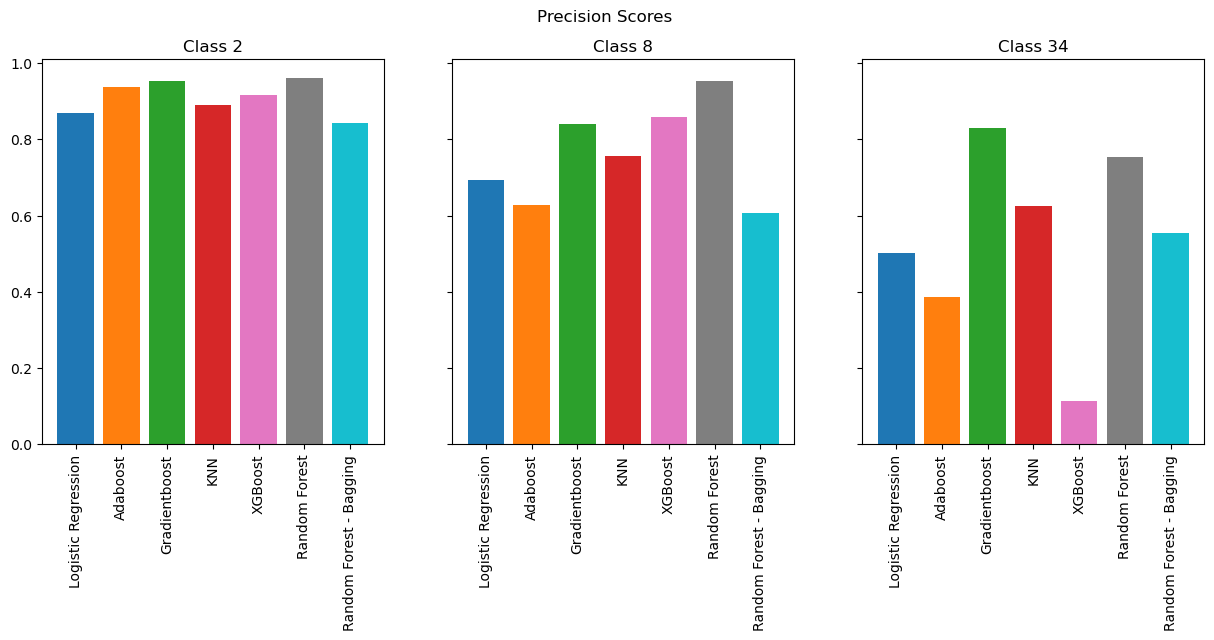

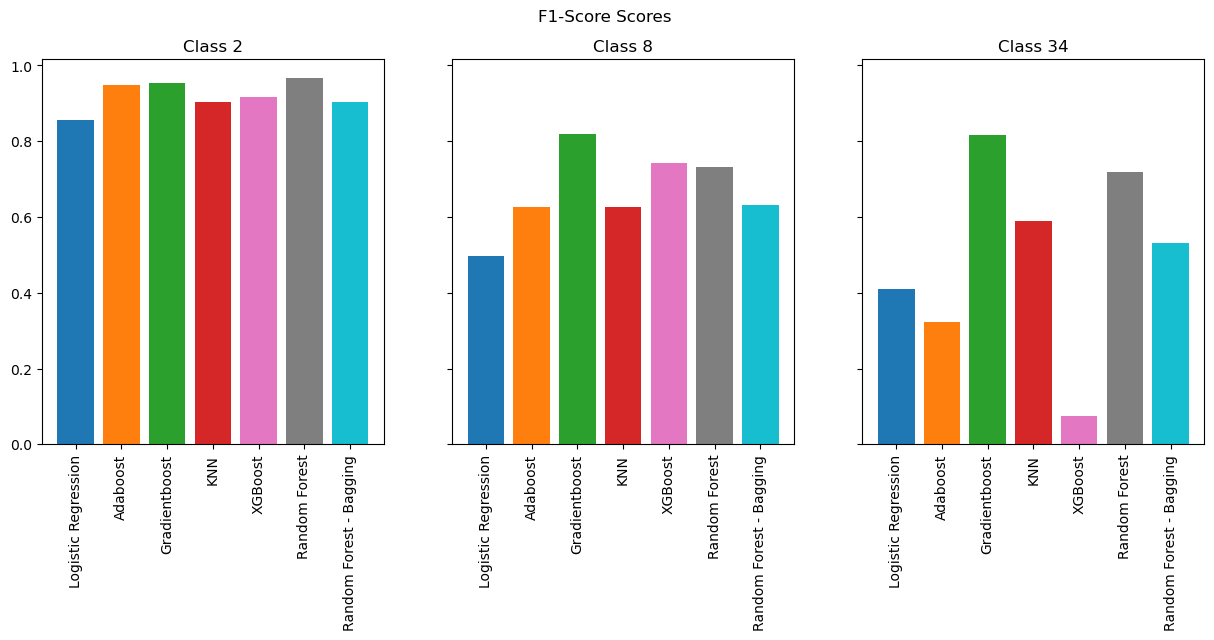

In [47]:
# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "Adaboost": 'tab:orange',
    "Gradientboost": 'tab:green',
    "KNN": 'tab:red',
    "XGBoost": 'tab:pink',
    "Random Forest": 'tab:gray',
    "Random Forest - Bagging": 'tab:cyan'
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")

        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)

        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=90)

    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')

    plt.show()




# Metric Table

In [48]:
# Concatenate them along rows
concatenated_data = pd.concat([metrics_2, metrics_8, metrics_34], ignore_index=False)

# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a DataFrame with the concatenated data
result_df = pd.DataFrame(concatenated_data.values,
                          pd.MultiIndex.from_product([["2 classes", "8 classes", "34 classes"], metrics]),
                          columns=model_names)

# Display the result
result_df


Logistic Regression  Adaboost Gradientboost       KNN  \
2 classes  Accuracy             0.987325    0.9951       0.99575  0.990788   
           Recall               0.844459  0.958733      0.954903  0.916986   
           Precision            0.869905   0.93737      0.952549  0.889666   
           F1-Score             0.856703  0.947783      0.953723  0.902836   
8 classes  Accuracy              0.82475  0.985012        0.9917  0.946163   
           Recall               0.476462  0.629999       0.80335  0.603714   
           Precision            0.693832  0.628506      0.839952  0.756951   
           F1-Score             0.497933  0.627205      0.820249  0.626488   
34 classes Accuracy             0.783575  0.723513       0.99035  0.932013   
           Recall               0.416319  0.348667      0.815507  0.580547   
           Precision            0.501909  0.385901      0.828673  0.625427   
           F1-Score             0.409058  0.323045      0.817736  0.589563   

                       XGBoost Random Forest Random Forest - Bagging  
2 classes  Accuracy   0.992387      0.996988                 0.98935  
           Recall     0.916244      0.973486                0.994027  
           Precision   0.91733      0.961723                0.843967  
           F1-Score   0.916786      0.967526                 0.90465  
8 classes  Accuracy     0.9936        0.9947                0.966337  
           Recall     0.721853       0.71562                0.789926  
           Precision  0.858733      0.951963                0.607234  
           F1-Score   0.741981      0.732571                0.630485  
34 classes Accuracy   0.270375       0.99285                0.906525  
           Recall      0.08718       0.71123                0.648675  
           Precision  0.113056      0.754803                0.553339  
           F1-Score   0.075797      0.719293                0.530971